In [47]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [48]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

## Подсчет смещения и разброса методов обучения

Будем использовать данные, сгенерированные следующим образом: x $-$ одномерное распределение (нормальное, экспоненциальное и равномерное), y $-$ сумма $cos(2\pi x)$ и случайного шума

In [49]:
x_nor = np.sort(np.random.normal(0, 0.3, size=100)).reshape(100, 1) #нормальное распределение
x_exp = np.sort(np.random.exponential(0.3, size=100)).reshape(100, 1) #экспоненциальное распределение
x_uni = np.sort(np.random.uniform(0, 1, size=100)).reshape(100, 1) #равномерное распределение
data_names = ['(Normal dist 0, 0.3)', '(Exponential dist 0.3)', '(Uniform dist [0,1])']

X = [x_nor, x_exp, x_uni]

noise = np.random.uniform(-0.2, 0.2, size=100).reshape(100, 1) #шум

y = [(np.cos(2*np.pi*x) + noise).reshape(100) for x in X]

Выведем сгенерированные данные

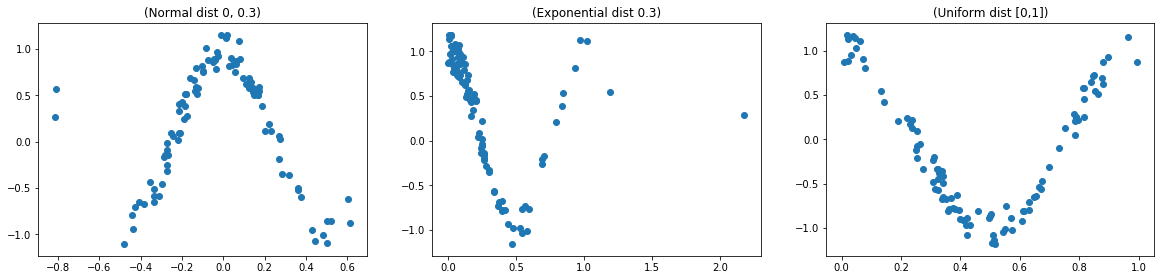

In [50]:
plt.figure(figsize=(20,30))
for i,x in enumerate(X):
    plt.subplot(6, 3, i+1)
    plt.title(data_names[i])
    plt.scatter(x, y[i])
plt.show()

Будем рассматривать 4 модели: Линейная регрессия, Решающее дерево, Случайный лес, Градиентный бустинг.

In [51]:
LReg = LinearRegression()
DTReg = DecisionTreeRegressor()
RFReg = RandomForestRegressor()
GBReg = GradientBoostingRegressor()

In [52]:
models = [LReg, DTReg, RFReg, GBReg]
names = ['Linear Regression', 'Decision Tree Regression', 'Random Forest Regression', 'Gradient Boosting Regression']

Обучим модели на сгенерированной выборке

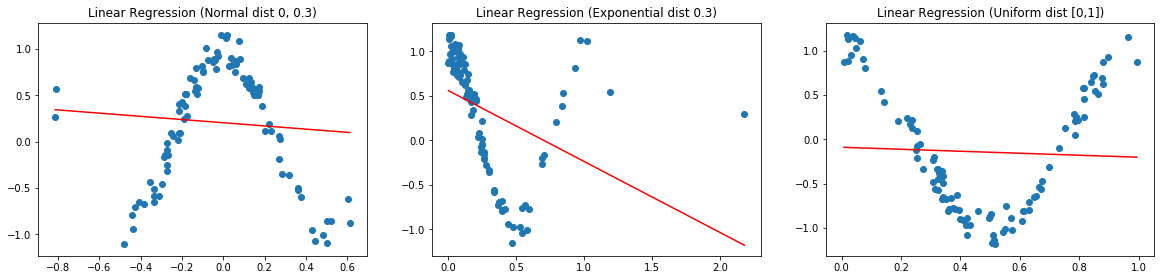

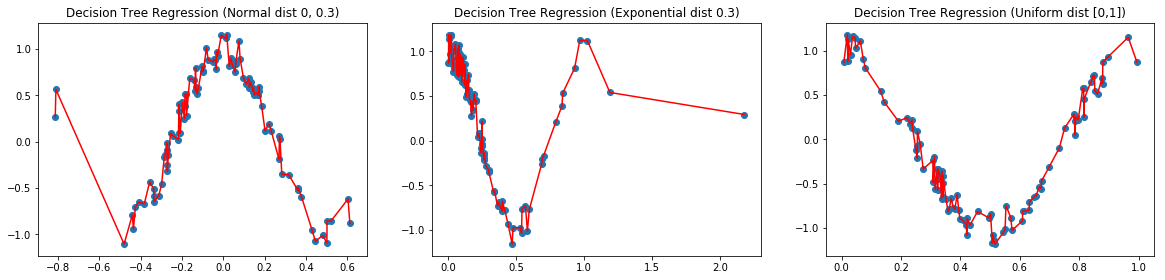

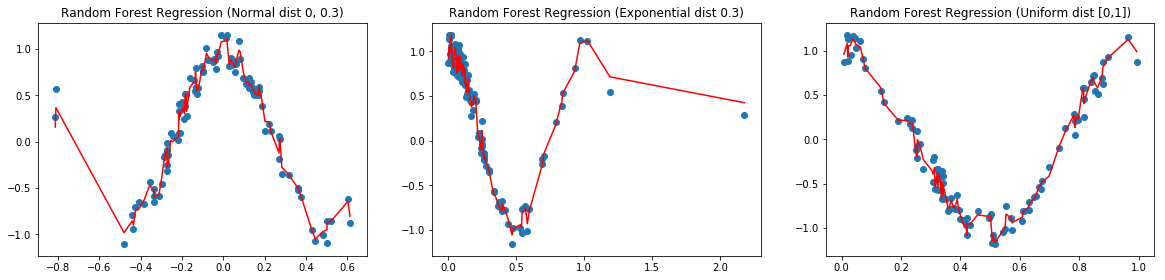

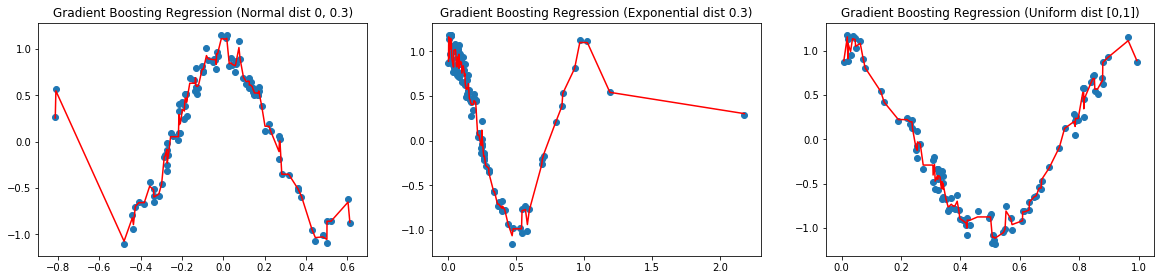

In [53]:
for j,model in enumerate(models):
    fig = plt.figure(figsize=(20,30))
    for i,x in enumerate(X):
        model.fit(x, y[i])
        plt.subplot(6, 3, i+1)
        plt.scatter(x, y[i])
        plt.plot(x, model.predict(x),'r')
        plt.title(names[j]+' '+data_names[i])
    plt.show()

Рассмотрим ансамбль моделей, обученных на разных выборках, и найдем среднюю кривую, как среднее арифметическое по ансамблю.

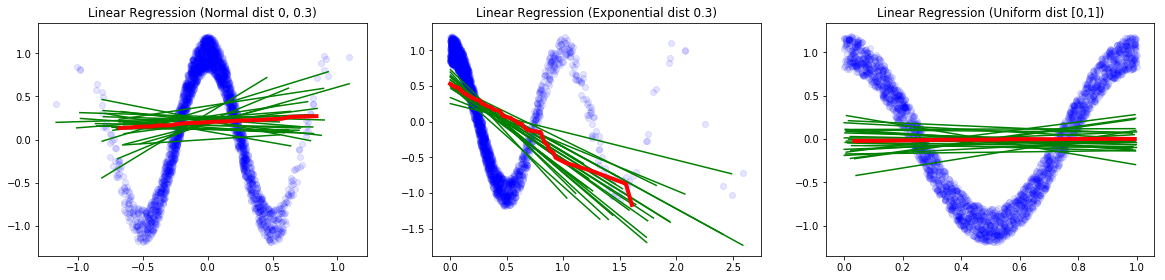

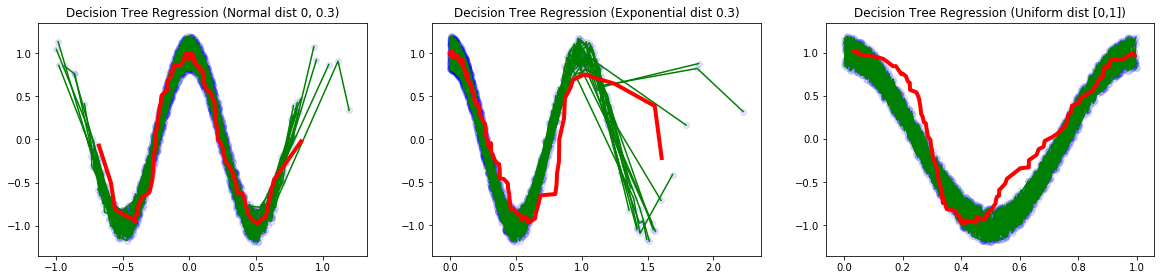

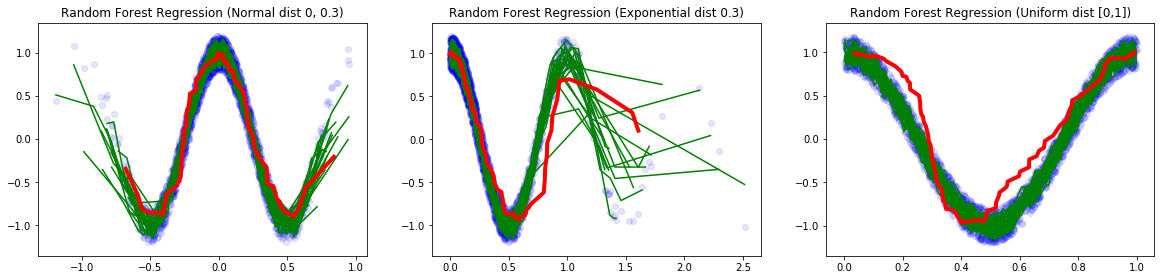

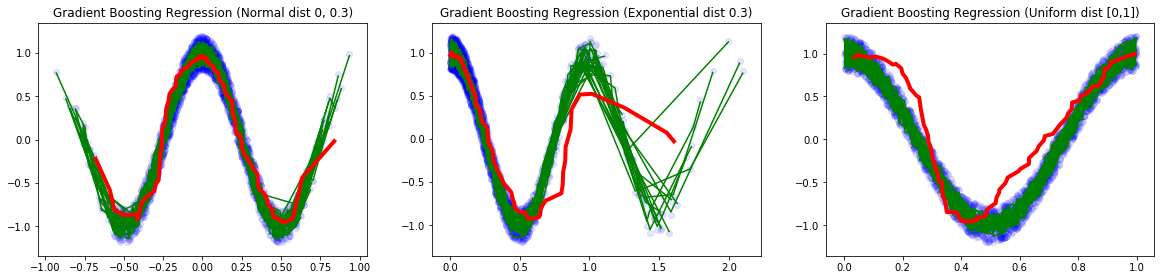

In [88]:
C = [] #массив усредненных моделей
for j,model in enumerate(models):
    plt.figure(figsize=(20,30))
    c_l = []
    for i in range(3):
        plt.subplot(6, 3, i+1)
        c_temp = np.zeros(100)
        for k in range(25): #ансабль из 25 выборок
            if i==0:
                x = np.sort(np.random.normal(0, 0.3, size=100)).reshape(100, 1)
            if i==1:
                x = np.sort(np.random.exponential(0.3, size=100)).reshape(100, 1)
            if i==2:
                x = np.sort(np.random.uniform(0, 1, size=100)).reshape(100, 1)
                
            noi = np.random.uniform(-0.2, 0.2, size=100).reshape(100, 1)
            y = (np.cos(2*np.pi*x) + noi).reshape(100)

            model.fit(x,y)
            plt.scatter(x, y, alpha = 0.1, c = 'b') #рисуем выборку полупрозрачным
            plt.plot(x, model.predict(x), c = 'g') #рисуем модель

            c_temp += model.predict(x)
        c_l.append(c_temp)    
        plt.plot(X[i], c_temp/25, c = 'r', linewidth = 4) #усредненная модель
        plt.title(names[j]+' '+data_names[i])
    C.append(c_l)

Найдем смещение и разброс методов обучения. 

Смещение - это среднее квадрата разности вектора зашумленных ответов и вектора предсказаний $ Bias= E_{x,y} ((E[y|x] - E_X [\mu(X)])^2)$. 

Разброс - это среднеквадратичное отклонение предсказания алгоритмов метода $\mu$ на объекте x от среднего предсказания $\mathbb{E}_X [\mu(X)]$
$ Variance=E_{x,y} (E_{X}(E_X [\mu(X)] - \mu(X)])^2)$

Мат.ожидание заменим на среднее арифметическое по выборке. $E[y|x] $ будем считать как сумму $cos(2\pi x)$ и среднего значения шума. $E_X [\mu(X)]$ возьмем как значение усредненной функции. 

In [82]:
mean = [np.zeros(100) for i in range(3)]
for i in range(100):
    x_nor = np.sort(np.random.normal(0, 0.3, size=100)).reshape(100, 1)
    x_exp = np.sort(np.random.exponential(0.3, size=100)).reshape(100, 1)
    x_uni = np.sort(np.random.uniform(0, 1, size=100)).reshape(100, 1)
    
    X = [x_nor, x_exp, x_uni]

    noise = np.random.uniform(-0.2, 0.2, size=100).reshape(100, 1)
    
    y = [(np.cos(2*np.pi*x) + noise).reshape(100) for x in X]
    
    for i,m in enumerate(mean):
        m += y[i]

Подсчет смещения

In [83]:
bias = np.zeros((4,3))
bias = [[np.mean((mean[i]/100 - C[j][i]/25)**2) for i in range(3)] for j in range(4)]

Подсчет разброса

In [84]:
var = np.zeros((4,3))
var = [[np.var(C[j][i]/25) for i in range(3)] for j in range(4)]

Выводрезультатов в виде таблиц

In [85]:
import pandas as pd

biases = pd.DataFrame(bias, columns=data_names, index=names)
variance = pd.DataFrame(var, columns=data_names, index=names)

In [86]:
biases

,"(Normal dist 0, 0.3)",(Exponential dist 0.3),"(Uniform dist [0,1])"
Linear Regression,0.430306,0.306309,0.468605
Decision Tree Regression,0.002009,0.001730,0.001004
Random Forest Regression,0.007865,0.003932,0.001987
Gradient Boosting Regression,0.002705,0.001712,0.002033


In [87]:
variance

,"(Normal dist 0, 0.3)",(Exponential dist 0.3),"(Uniform dist [0,1])"
Linear Regression,0.000056,0.104367,0.000012
Decision Tree Regression,0.421092,0.439213,0.469727
Random Forest Regression,0.402102,0.444133,0.472638
Gradient Boosting Regression,0.432546,0.433769,0.475804
